# COVID-19 in South Korea analysis

In this project we will have a general overlook of the Covid-19 situation in South Korea. Data is available up until the end of June. 
- We will look into the data and try to draw insights about pandemic situation in accordance with gender, age and region;
- We will look into the numbers of infected/deceased cases; 
- We will try to engineer some new features and group the data based on patient's behavioural data with PCA and t-SNE;
- We will perform statistical testing on some of the data;
- We will build logistic regression model and try to predict the state of the patient (whether he is in isolation or released) based on his behavioural data.

So let's import the libraries and dig into the data we have available to us!

In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import folium 
from matplotlib import pyplot as plt
from folium import plugins
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
import plotly.express as px
from statsmodels.stats import weightstats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
case = pd.read_csv(os.getcwd() + '/sample_data/Case.csv')
seoul_floating = pd.read_csv(os.getcwd() + '/sample_data/SeoulFloating.csv')
policy = pd.read_csv(os.getcwd() + '/sample_data/Policy.csv')
patient_info = pd.read_csv(os.getcwd() + '/sample_data/PatientInfo.csv')
time_gender = pd.read_csv(os.getcwd() + '/sample_data/TimeGender.csv')
time_province = pd.read_csv(os.getcwd() + '/sample_data/TimeProvince.csv')
search_trend = pd.read_csv(os.getcwd() + '/sample_data/SearchTrend.csv')
weather = pd.read_csv(os.getcwd() + '/sample_data/Weather.csv')
time = pd.read_csv(os.getcwd() + '/sample_data/Time.csv')
region = pd.read_csv(os.getcwd() + '/sample_data/Region.csv')
time_age = pd.read_csv(os.getcwd() + '/sample_data/TimeAge.csv')

In [3]:
case.head()

case_id province          city  group               infection_case  \
0   1000001    Seoul    Yongsan-gu   True                Itaewon Clubs   
1   1000002    Seoul     Gwanak-gu   True                      Richway   
2   1000003    Seoul       Guro-gu   True          Guro-gu Call Center   
3   1000004    Seoul  Yangcheon-gu   True  Yangcheon Table Tennis Club   
4   1000005    Seoul     Dobong-gu   True              Day Care Center   

   confirmed   latitude   longitude  
0        139  37.538621  126.992652  
1        119   37.48208  126.901384  
2         95  37.508163  126.884387  
3         43  37.546061  126.874209  
4         43  37.679422  127.044374

In [4]:
seoul_floating.head()

date  hour  birth_year     sex province           city  fp_num
0  2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1  2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2  2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
3  2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050
4  2020-01-01     0          20  female    Seoul     Dongjag-gu   28880

In [5]:
policy.head()

policy_id country         type                      gov_policy  \
0          1   Korea        Alert  Infectious Disease Alert Level   
1          2   Korea        Alert  Infectious Disease Alert Level   
2          3   Korea        Alert  Infectious Disease Alert Level   
3          4   Korea        Alert  Infectious Disease Alert Level   
4          5   Korea  Immigration   Special Immigration Procedure   

             detail  start_date    end_date  
0    Level 1 (Blue)  2020-01-03  2020-01-19  
1  Level 2 (Yellow)  2020-01-20  2020-01-27  
2  Level 3 (Orange)  2020-01-28  2020-02-22  
3     Level 4 (Red)  2020-02-23         NaN  
4        from China  2020-02-04         NaN

In [6]:
patient_info.head()

patient_id     sex  age country province         city  \
0  1000000001    male  50s   Korea    Seoul   Gangseo-gu   
1  1000000002    male  30s   Korea    Seoul  Jungnang-gu   
2  1000000003    male  50s   Korea    Seoul    Jongno-gu   
3  1000000004    male  20s   Korea    Seoul      Mapo-gu   
4  1000000005  female  20s   Korea    Seoul  Seongbuk-gu   

         infection_case infected_by contact_number symptom_onset_date  \
0       overseas inflow         NaN             75         2020-01-22   
1       overseas inflow         NaN             31                NaN   
2  contact with patient  2002000001             17                NaN   
3       overseas inflow         NaN              9         2020-01-26   
4  contact with patient  1000000002              2                NaN   

  confirmed_date released_date deceased_date     state  
0     2020-01-23    2020-02-05           NaN  released  
1     2020-01-30    2020-03-02           NaN  released  
2     2020-01-30    2020-02-19           NaN  released  
3     2020-01-30    2020-02-15           NaN  released  
4     2020-01-31    2020-02-24           NaN  released

In [7]:
time_gender.head()

date  time     sex  confirmed  deceased
0  2020-03-02     0    male       1591        13
1  2020-03-02     0  female       2621         9
2  2020-03-03     0    male       1810        16
3  2020-03-03     0  female       3002        12
4  2020-03-04     0    male       1996        20

In [8]:
time_province.tail()

date  time          province  confirmed  released  deceased
2766  2020-06-30     0      Jeollabuk-do         27        21         0
2767  2020-06-30     0      Jeollanam-do         24        19         0
2768  2020-06-30     0  Gyeongsangbuk-do       1389      1328        54
2769  2020-06-30     0  Gyeongsangnam-do        134       128         0
2770  2020-06-30     0           Jeju-do         19        16         0

In [9]:
search_trend.tail()

date     cold      flu  pneumonia  coronavirus
1637  2020-06-25  0.12072  0.04190    0.11936      2.16993
1638  2020-06-26  0.11381  0.03027    0.11317      2.15139
1639  2020-06-27  0.10554  0.02136    0.08354      1.96848
1640  2020-06-28  0.12563  0.02872    0.08072      2.19720
1641  2020-06-29  0.14263  0.04308    0.11254      2.41501

In [10]:
weather.head()

code province        date  avg_temp  min_temp  max_temp  precipitation  \
0  10000    Seoul  2016-01-01       1.2      -3.3       4.0            0.0   
1  11000    Busan  2016-01-01       5.3       1.1      10.9            0.0   
2  12000    Daegu  2016-01-01       1.7      -4.0       8.0            0.0   
3  13000  Gwangju  2016-01-01       3.2      -1.5       8.1            0.0   
4  14000  Incheon  2016-01-01       3.1      -0.4       5.7            0.0   

   max_wind_speed  most_wind_direction  avg_relative_humidity  
0             3.5                 90.0                   73.0  
1             7.4                340.0                   52.1  
2             3.7                270.0                   70.5  
3             2.7                230.0                   73.1  
4             5.3                180.0                   83.9

In [11]:
time.head()

date  time  test  negative  confirmed  released  deceased
0  2020-01-20    16     1         0          1         0         0
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0

In [12]:
region.head()

code province         city   latitude   longitude  \
0  10000    Seoul        Seoul  37.566953  126.977977   
1  10010    Seoul   Gangnam-gu  37.518421  127.047222   
2  10020    Seoul  Gangdong-gu  37.530492  127.123837   
3  10030    Seoul   Gangbuk-gu  37.639938  127.025508   
4  10040    Seoul   Gangseo-gu  37.551166  126.849506   

   elementary_school_count  kindergarten_count  university_count  \
0                      607                 830                48   
1                       33                  38                 0   
2                       27                  32                 0   
3                       14                  21                 0   
4                       36                  56                 1   

   academy_ratio  elderly_population_ratio  elderly_alone_ratio  \
0           1.44                     15.38                  5.8   
1           4.18                     13.17                  4.3   
2           1.54                     14.55                  5.4   
3           0.67                     19.49                  8.5   
4           1.17                     14.39                  5.7   

   nursing_home_count  
0               22739  
1                3088  
2                1023  
3                 628  
4                1080

In [13]:
time_age.head()

date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         0
1  2020-03-02     0  10s        169         0
2  2020-03-02     0  20s       1235         0
3  2020-03-02     0  30s        506         1
4  2020-03-02     0  40s        633         1

# Exploratory data analysis

Let's start EDA by looking at the age of infected/deceased people as of 2020-06-30.
We can see that people in their 20s tend to get infected a lot more.
1. Social Factors
    - 20s tend to have more social activities than the others
2. Romantic Factors
    - 20s are the peak of romantic seasons biologically
3. Psychological Factors
    - COVID-19 is critically dangerous to the elders
    - COVID-19 might seem "just" another type of flu or cold for some youngers
    - This could make them take containing efforts (like quarantine and social distancing) less seriously

In [14]:
def autolabel(bar_plot):
    """
    Attach a text label above each bar displaying its height
    """
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

Text(0.5, 1.0, 'Confirmed infection and deceased numbers by age')

<Figure size 1080x576 with 0 Axes>

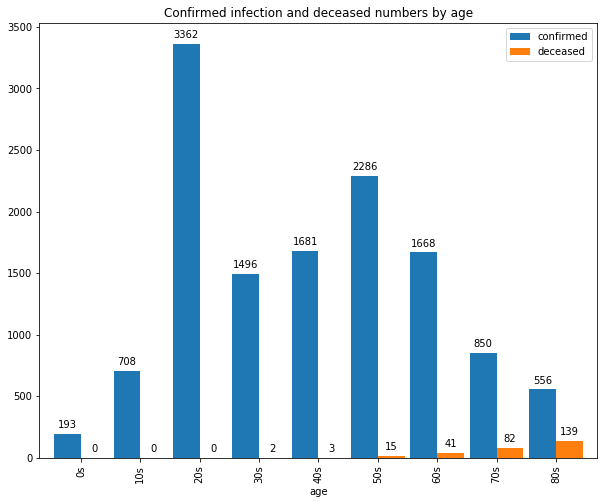

In [15]:
plt.figure(figsize = (15,8))
age_cases = pd.DataFrame({'confirmed':time_age.groupby('age')['confirmed'].max(), 'deceased':time_age.groupby('age')['deceased'].max()}).reset_index()
ax = age_cases.plot(x="age", y=['confirmed', 'deceased'], kind="bar", width=0.9, figsize=(10,8))
autolabel(ax)
plt.title("Confirmed infection and deceased numbers by age", horizontalalignment="center", fontsize=12)

- A peek into infection numbers by gender:

Text(0.5, 1.0, 'Confirmed infection cases by gender')

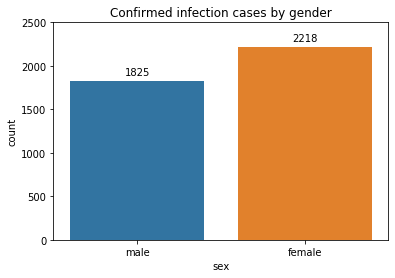

In [16]:
ax = sns.countplot(patient_info['sex'])
ax.set_ylim([0,2500])
autolabel(ax)
plt.title("Confirmed infection cases by gender", horizontalalignment="center", fontsize=12)

- Infection cases by age group and gender:

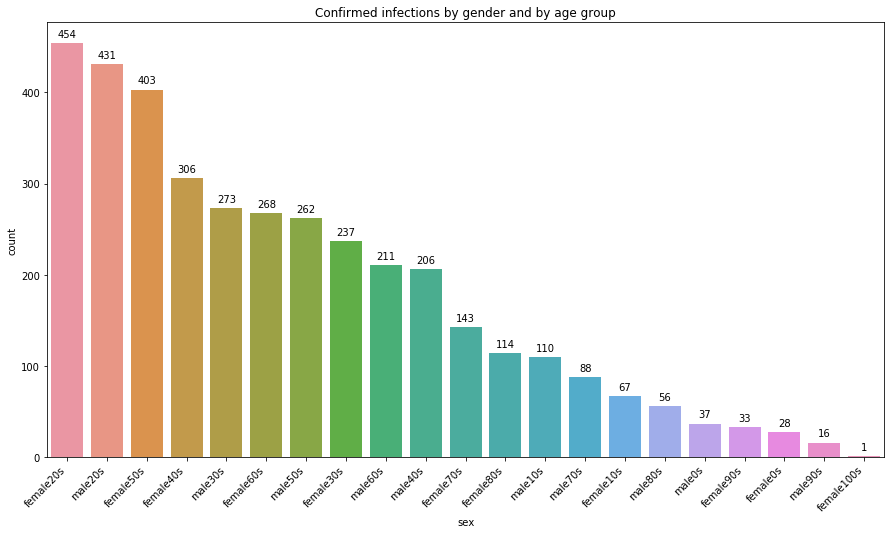

In [17]:
patient_info = patient_info[patient_info['country'] == 'Korea']

plt.figure(figsize = (15,8))
data = patient_info['sex'].str.cat(patient_info['age'])
ax = sns.countplot(data, order = data.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
autolabel(ax)
plt.title("Confirmed infections by gender and by age group", horizontalalignment="center", fontsize=12)
plt.show()

- Infection cases. Most frequent are: overseas inflow, contact with patients, various facilities (group) and etc (unknown).

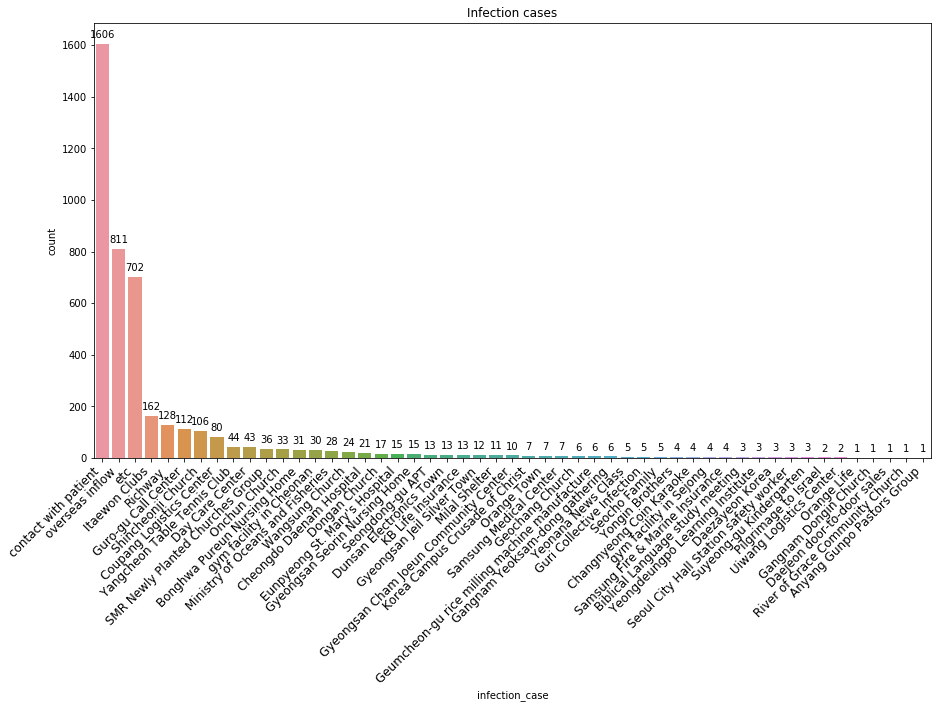

In [18]:
plt.figure(figsize = (15,8))
ax = sns.countplot(patient_info['infection_case'], order = patient_info['infection_case'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
autolabel(ax)
plt.title("Infection cases", horizontalalignment="center", fontsize=12)
plt.show()

- Most infected provinces. Gyeonggi-do is a province surrounding the capital. Gyeongsangbuk-do is, however, not one of the densier areas of South Korea (eastern coast)

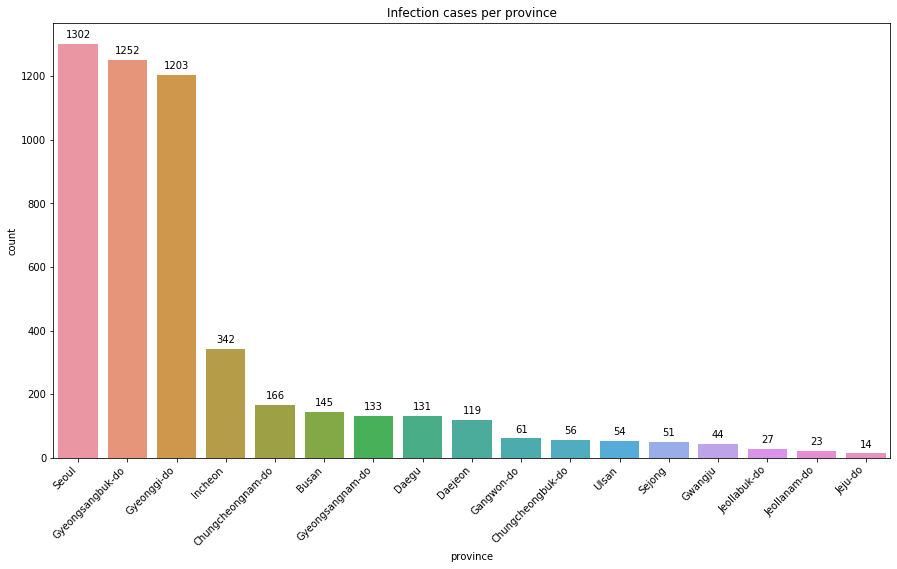

In [19]:
plt.figure(figsize = (15,8))
ax = sns.countplot(patient_info['province'], order = patient_info['province'].value_counts().index)
autolabel(ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Infection cases per province", horizontalalignment="center", fontsize=12)
plt.show()

- Total confirmed and deceased cases over time in S. Korea. Exponential at first, they gradually become flattened with constant increase.

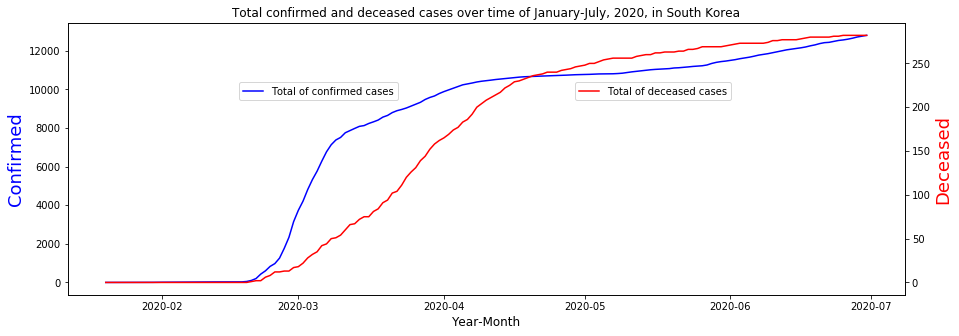

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pd.to_datetime(time['date']), time['confirmed'], color='blue', label='Total of confirmed cases')
ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Confirmed', fontsize=18, color='blue')
plt.legend(bbox_to_anchor=(0.4,0.8))
ax2 = ax.twinx()
ax2.plot(pd.to_datetime(time['date']), time['deceased'], color='red', label='Total of deceased cases')
ax2.set_ylabel('Deceased', fontsize=18, color='red')
plt.legend(bbox_to_anchor=(0.6,0.8))
ax.set_title("Total confirmed and deceased cases over time of January-July, 2020, in South Korea", fontsize=12)
plt.show()

- Let's draw a heatmap of patients in South Korea.
Group by coordinates, create folium map and make heatmap

In [21]:
regional_patient = pd.merge(patient_info[['patient_id','confirmed_date','sex','age','province','city']],
                            region[['province','city','latitude','longitude']], how = 'left', on = ['province','city'])

heat_data = regional_patient.groupby(['latitude','longitude'])['patient_id'].count().reset_index().values.tolist()
m = folium.Map([36, 128], zoom_start=7)
folium.plugins.HeatMap(heat_data).add_to(m)

<img src="pictures/korea.png">

- Total count of confirmed cases over time of March-July, 2020, in South Korea for both genders

Text(0.5, 1.0, 'Total count of confirmed cases over time of March-July, 2020, in South Korea (Genders)')

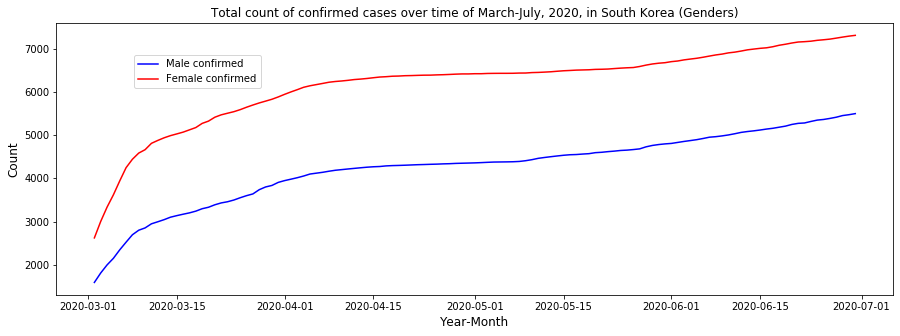

In [22]:
time_males = time_gender[time_gender['sex'] == 'male']
time_females = time_gender[time_gender['sex'] == 'female']

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pd.to_datetime(time_males['date']), time_males['confirmed'], color='blue', label='Male confirmed')
ax.plot(pd.to_datetime(time_females['date']), time_females['confirmed'], color='Red', label='Female confirmed')
plt.legend(bbox_to_anchor=(0.25,0.9))

ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title("Total count of confirmed cases over time of March-July, 2020, in South Korea (Genders)", fontsize=12)

- Total count of deceased cases over time of March-July, 2020, in South Korea for both genders

Text(0.5, 1.0, 'Total count of deceased cases over time of March-July, 2020, in South Korea (Genders)')

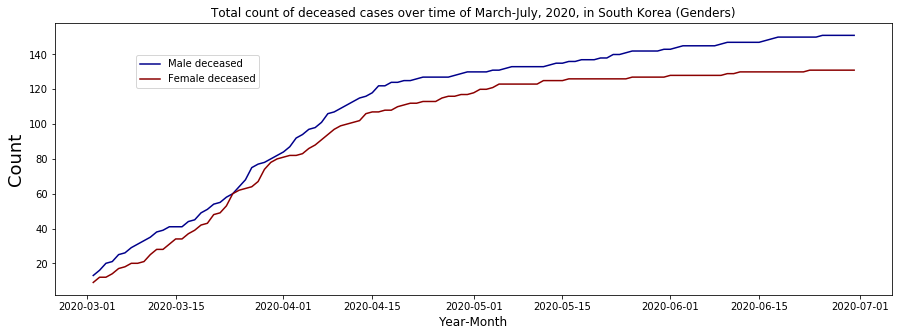

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pd.to_datetime(time_males['date']), time_males['deceased'], color='darkblue', label='Male deceased')
ax.plot(pd.to_datetime(time_females['date']), time_females['deceased'], color='darkred', label='Female deceased')
plt.legend(bbox_to_anchor=(0.25,0.9))
ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Count', fontsize=18)
ax.set_title("Total count of deceased cases over time of March-July, 2020, in South Korea (Genders)", fontsize=12)

# PCA

Let's cluster data by behavioural patterns.
- Unique infection cases:

In [24]:
infection_cases = patient_info.copy()
infection_cases['infection_case'].unique(), len(infection_cases['infection_case'].unique())

(array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
        'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
        'Dongan Church', 'Guro-gu Call Center', nan, 'Itaewon Clubs',
        'Samsung Medical Center', 'Biblical Language study meeting',
        'Coupang Logistics Center', 'Guri Collective Infection',
        'KB Life Insurance', 'Gangnam Dongin Church',
        'Korea Campus Crusade of Christ',
        'Yeongdeungpo Learning Institute', 'Yeonana News Class',
        'SMR Newly Planted Churches Group', 'Seocho Family',
        'Anyang Gunpo Pastors Group', 'Richway',
        'Samsung Fire & Marine Insurance', 'Yangcheon Table Tennis Club',
        'Yongin Brothers', 'Day Care Center',
        'Geumcheon-gu rice milling machine manufacture', 'Daezayeon Korea',
        'Orange Life', 'Daejeon door-to-door sales',
        'Seoul City Hall Station safety worker', 'Uiwang Logistics Center',
        'Wangsung Church', 'Gangnam Yeoksam-dong gathering'

- It would be difficult to see a case of only one person in the data as a "population infection". 
Likewise, the value to which a small number of people belong may appear as a group by itself, 
but it is difficult to say that it is actually a group infection. Therefore, the 'group' value 
is assigned only when the number of confirmed patients with the corresponding value is at least 5, and the rest are not used.

In [25]:
cases = infection_cases.groupby(['infection_case'])['patient_id'].count()
cases = pd.DataFrame(cases)

infection_case_less_than_5 = cases[cases['patient_id'] < 5].index.tolist()

- Filter out infection cases where number of infected people is less than 5

In [26]:
infection_cases = infection_cases[~(infection_cases['infection_case'].isin(infection_case_less_than_5))]
infection_cases.shape

(5083, 14)

- Infection cases comprise a lot of NaN values (almost 20%) and it wouldn't be wise to just drop them.
Instead, we can assume than NaN is the same as unknown (etc)

In [27]:
infection_cases[infection_cases['infection_case'].isna()].shape

(913, 14)

In [28]:
def categorisation(old_val):
    if old_val == 'overseas inflow':
        new_val = 'overseas'
    elif old_val == 'contact with patient': 
        new_val = 'individual'
    elif (old_val == 'etc') | (pd.isna(old_val)):
        new_val = 'unknown'
    else: 
        new_val = 'group' 
    
    return new_val

In [29]:
infection_cases['infection'] = infection_cases['infection_case'].apply(lambda x: categorisation(x))

- If we redraw infection case graph shown above, we can expect some meaningful distribution of infection cases 

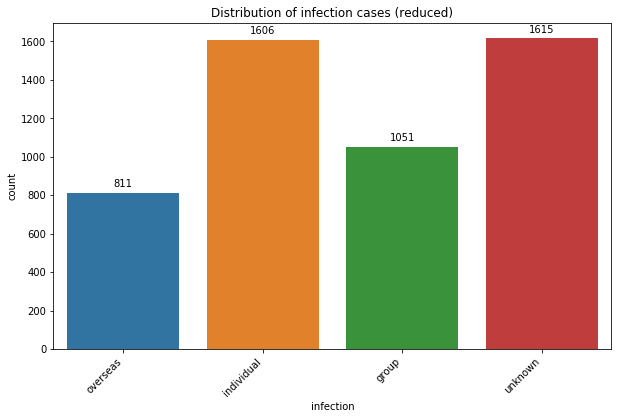

In [30]:
plt.figure(figsize = (10,6))
ax = sns.countplot(infection_cases['infection'])
autolabel(ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of infection cases (reduced)', horizontalalignment="center", fontsize=12)
plt.show()

- Some feature engineering - creation of diagnosis time column.
The time it takes to be confirmed refers to how soon you were diagnosed with COVID-19 after your symptoms first appeared. 
The time taken to receive confirmation can be regarded as a behavioral characteristic because the value can vary according to a person's choice/behavior.

In [31]:
print('data shape:', infection_cases.shape)
print('missing values in symptom_onset_date:', infection_cases[infection_cases['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', infection_cases[infection_cases['confirmed_date'].isna()].shape)

data shape: (5083, 15)
missing values in symptom_onset_date: (4408, 15)
missing values in confirmed_date: (3, 15)


- Corona is known for being able to show no symptoms even if a person carries a virus.
In this case the time between symptom appearance and confirmation would be assumed to be 0.
Since this assumption makes little sense, we have to drop NaN values.
Also drop NaN from number of contacts.
- Some feature engineering is applied to create a new column, containing information about number of days passed since symptom onset to infection verification.

In [32]:
print('original data shape: ', infection_cases.shape)
infection_cases = infection_cases[infection_cases['symptom_onset_date'].notna() & infection_cases['contact_number'].notna()]
print('data excluding missing values in symptom_onset_date and contact_number: ', infection_cases.shape)

original data shape:  (5083, 15)
data excluding missing values in symptom_onset_date and contact_number:  (253, 15)


In [33]:
infection_cases['symptom_onset_date'] = pd.to_datetime(infection_cases['symptom_onset_date'], errors='coerce')
infection_cases['confirmed_date'] = pd.to_datetime(infection_cases['confirmed_date'], errors='coerce')

In [34]:
infection_cases['contact_number'] = pd.to_numeric(infection_cases['contact_number'], errors='coerce')

In [35]:
infection_cases = infection_cases[infection_cases['symptom_onset_date'].notnull() & infection_cases['confirmed_date'].notnull() & infection_cases['contact_number'].notnull()]

In [36]:
infection_cases['days_notice'] = infection_cases['confirmed_date'] - infection_cases['symptom_onset_date'] 
infection_cases['hours_notice'] = infection_cases['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
infection_cases['days'] = infection_cases['hours_notice'].apply(lambda x: int(x/24))

- Now we have three behavioural characteristics to be used for PCA:
1) infection route type, 2) contact degree 3) time from symptoms to confirmation

In [37]:
infection_cases.head()

patient_id     sex  age country province          city  \
0    1000000001    male  50s   Korea    Seoul    Gangseo-gu   
3    1000000004    male  20s   Korea    Seoul       Mapo-gu   
13   1000000014  female  60s   Korea    Seoul     Jongno-gu   
14   1000000015    male  70s   Korea    Seoul  Seongdong-gu   
301  1000000302    male  10s   Korea    Seoul    Dongjak-gu   

           infection_case infected_by  contact_number symptom_onset_date  \
0         overseas inflow         NaN            75.0         2020-01-22   
3         overseas inflow         NaN             9.0         2020-01-26   
13   contact with patient  1000000013            27.0         2020-02-06   
14       Seongdong-gu APT         NaN             8.0         2020-02-11   
301       overseas inflow         NaN             8.0         2020-03-19   

    confirmed_date released_date deceased_date     state   infection  \
0       2020-01-23    2020-02-05           NaN  released    overseas   
3       2020-01-30    2020-02-15           NaN  released    overseas   
13      2020-02-16    2020-03-12           NaN  released  individual   
14      2020-02-19           NaN           NaN  released       group   
301     2020-03-20           NaN           NaN  released    overseas   

    days_notice  hours_notice  days  
0        1 days          24.0     1  
3        4 days          96.0     4  
13      10 days         240.0    10  
14       8 days         192.0     8  
301      1 days          24.0     1

- Let's prepare data for pca

In [38]:
infection_pca = infection_cases[['patient_id', 'infection', 'days', 'contact_number']]
infection_pca.reset_index(drop = True, inplace = True)

- Convert infection categorical variable to numerical using one-hot encoding:

In [39]:
infection_pca = pd.get_dummies(infection_pca, columns=['infection'])

- Now we scale values and apply pca on behavioural data

In [40]:
scaler = StandardScaler()
infection_pca = scaler.fit_transform(infection_pca)

pca = PCA(n_components = 2)
principalComponents = pca.fit(infection_pca)
principalComponents.explained_variance_ratio_

array([0.21291575, 0.20411396])

- First two components explain only 41% of the variance. It's really low, but let's see what do we get from it.

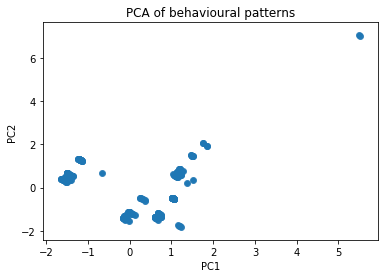

In [41]:
principalComponents = pca.fit_transform(infection_pca)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
ax = sns.scatterplot(x='PC1', y='PC2', data = principalDF) 
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)
ax.set_title("PCA of behavioural patterns")

display()

- Elbow method for K-means. We can assume 4 to 6 possible clusters.

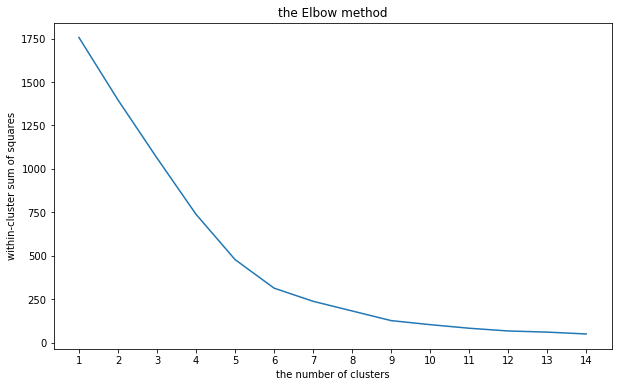

In [42]:
cluster_range = range(1,15)
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(infection_pca)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (10,6))
plt.plot(cluster_range, cluster_errors)
x_ticks = np.arange(1, 15, 1)
plt.xticks(x_ticks)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

- As we saw in pca plot, 5 clusters might be optimal

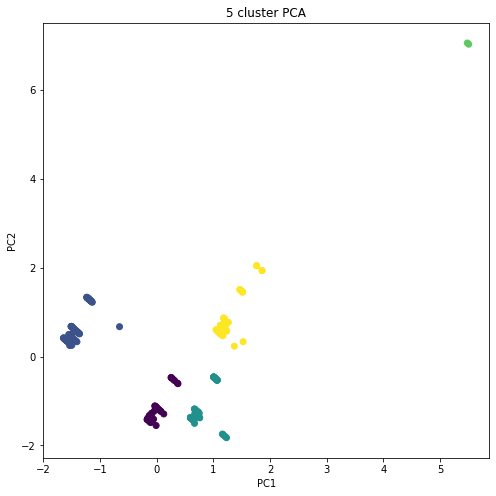

In [43]:
km = KMeans(n_clusters = 5)
km.fit(infection_pca)

centroids = km.cluster_centers_ 
labels = km.labels_
infection_cases['label'] = labels

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(infection_pca)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

plt.title('5 cluster PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

display()

- Let's try to remove these two outliers and plot everything again. First, we find which rows are they:

In [44]:
infection_cases.groupby(['label'])['patient_id'].count()

label
0    45
1    90
2    63
3     2
4    51
Name: patient_id, dtype: int64

- If we look at the rows which have lowest count, we remove outlier rows:

In [45]:
infection_cases = infection_cases[(infection_cases['patient_id'] != 6100000097) & (infection_cases['patient_id'] != 6100000098)]

- Now that outliers are removed, let's repeat processing and clustering part again:

In [46]:
infection_cases.drop(['label'], axis=1, inplace=True)
infection_cases.head()

patient_id     sex  age country province          city  \
0    1000000001    male  50s   Korea    Seoul    Gangseo-gu   
3    1000000004    male  20s   Korea    Seoul       Mapo-gu   
13   1000000014  female  60s   Korea    Seoul     Jongno-gu   
14   1000000015    male  70s   Korea    Seoul  Seongdong-gu   
301  1000000302    male  10s   Korea    Seoul    Dongjak-gu   

           infection_case infected_by  contact_number symptom_onset_date  \
0         overseas inflow         NaN            75.0         2020-01-22   
3         overseas inflow         NaN             9.0         2020-01-26   
13   contact with patient  1000000013            27.0         2020-02-06   
14       Seongdong-gu APT         NaN             8.0         2020-02-11   
301       overseas inflow         NaN             8.0         2020-03-19   

    confirmed_date released_date deceased_date     state   infection  \
0       2020-01-23    2020-02-05           NaN  released    overseas   
3       2020-01-30    2020-02-15           NaN  released    overseas   
13      2020-02-16    2020-03-12           NaN  released  individual   
14      2020-02-19           NaN           NaN  released       group   
301     2020-03-20           NaN           NaN  released    overseas   

    days_notice  hours_notice  days  
0        1 days          24.0     1  
3        4 days          96.0     4  
13      10 days         240.0    10  
14       8 days         192.0     8  
301      1 days          24.0     1

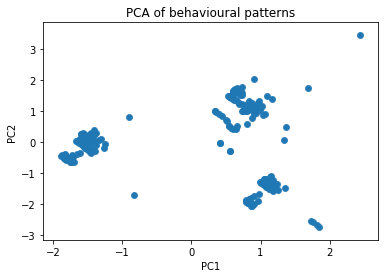

In [47]:
infection_pca = infection_cases[['patient_id', 'infection', 'days', 'contact_number']]
infection_pca.reset_index(drop = True, inplace = True)
infection_pca = pd.get_dummies(infection_pca, columns=['infection'])

scaler = StandardScaler()
infection_pca = scaler.fit_transform(infection_pca)

pca = PCA(n_components = 2)
principalComponents = pca.fit(infection_pca)
principalComponents.explained_variance_ratio_

principalComponents = pca.fit_transform(infection_pca)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
ax = sns.scatterplot(x='PC1', y='PC2', data = principalDF) 
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)
ax.set_title("PCA of behavioural patterns")

display()

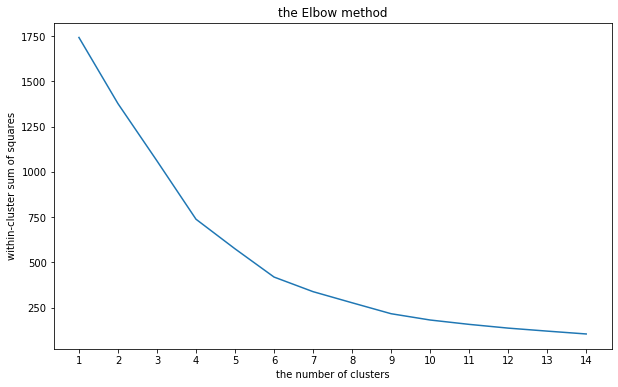

In [48]:
cluster_range = range(1,15)
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(infection_pca)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (10,6))
plt.plot(cluster_range, cluster_errors)
x_ticks = np.arange(1, 15, 1)
plt.xticks(x_ticks)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

- 4 clusters are now reasonable:

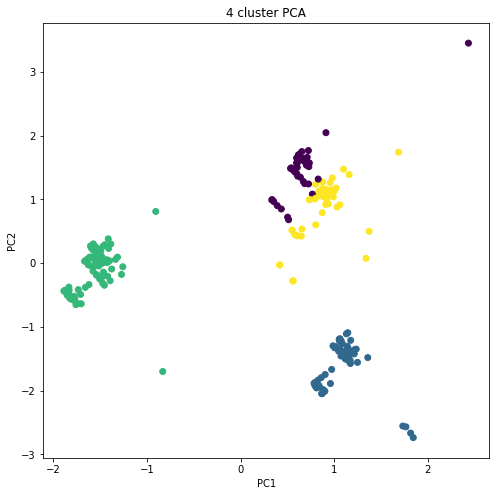

In [49]:
km = KMeans(n_clusters = 4)
km.fit(infection_pca)

centroids = km.cluster_centers_ 
labels = km.labels_
infection_cases['label'] = labels

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(infection_pca)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

plt.title('4 cluster PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

display()

- Let's create hover pca plot to look into clusters

In [50]:
infection_cases = pd.concat([infection_cases.reset_index(drop=True), principalDF], axis=1)

# Set up colour scheme for cluster
# Cluster name dictionary (by cluster label)
cluster_dic = {}
for label, infection in zip(infection_cases['label'], infection_cases['infection']):
    cluster_dic[label] = infection

# Draw 2 dimensional reduced scatter plot
layout = { 
  "title": "Fours types of infections by behavioural patterns",  
  "plot_bgcolor": "rgb(252,252,252)"
}
 
fig = px.scatter(infection_cases, x = 'PC1', y = 'PC2', 
                  color = 'label', 
                  hover_data = ['contact_number', 'infection', 'days'],
                  width=700, height=700)

fig.update(layout = layout)
fig.show()

<img src="pictures/pcapx.png">

# t-SNE
Let's try t-SNE clustering on behavioural data. The process is the same as for pca clustering, but only with tsne data.

In [51]:
infection_cases_tsne = infection_cases.copy()
infection_tsne = infection_cases_tsne[['patient_id', 'infection', 'days', 'contact_number']]
infection_tsne.reset_index(drop = True, inplace = True)
infection_tsne = pd.get_dummies(infection_tsne, columns=['infection'])

scaler = StandardScaler()
infection_tsne = scaler.fit_transform(infection_tsne)

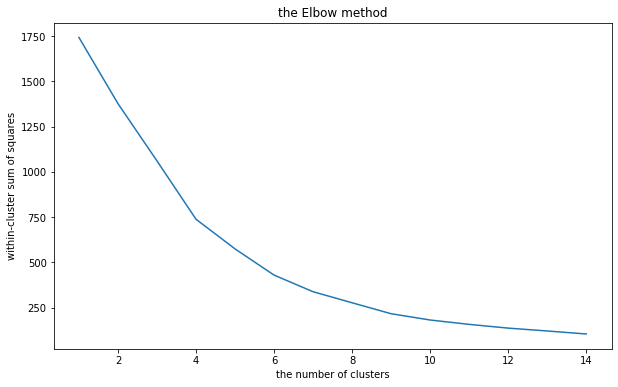

In [52]:
cluster_range = range(1,15)
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(infection_tsne)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (10,6))
plt.plot(cluster_range, cluster_errors)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

In [53]:
km = KMeans(n_clusters = 4)
km.fit(infection_tsne)

centroids = km.cluster_centers_ 
labels = km.labels_
infection_cases_tsne['label'] = labels

In [54]:
tsne = TSNE(n_components=2).fit_transform(infection_tsne)
tsneDF = pd.DataFrame(data = tsne, columns = ['TSNE1','TSNE2'])

infection_cases_tsne = pd.concat([infection_cases_tsne.reset_index(drop=True), tsneDF], axis=1)

cluster_dic = {}
for label, infection in zip(infection_cases_tsne['label'], infection_cases_tsne['infection']):
    cluster_dic[label] = infection

layout = { 
  "title": "Fours types of infections by behavioural patterns with t-SNE",  
  "plot_bgcolor": "rgb(252,252,252)"
}
 
fig = px.scatter(infection_cases_tsne, x = 'TSNE1', y = 'TSNE2', 
                  color = 'label', 
                  hover_data = ['contact_number', 'infection', 'days'],
                  width=700, height=700)

fig.update(layout = layout)
fig.show()

<img src="pictures/tsnepx.png">

- It seems with t-SNE we can discern clusters with each of them having different infection case. 

# Statistical testing

In this section we will look at the daily numbers of infected people gender-wise and use z testing to determine whether two groups are statistically different.

- Null hyphotesis: there is no difference between infected male and female populations
- Alternative hypothesis: infected male and female populations are significantly different

with z-testing we will try to reject null hypothesis with 95% confidence. We will calculate z-score and p-value for 95% confidence. If z-score is larger than 1.96 and p-value is smaller than 0.05, we will reject null hypothesis and assume that two populations are significantly different.

In [55]:
time_males3 = time_males.copy()
time_males3['confirmed'] = time_males3['confirmed'].diff()
time_males3.dropna(inplace=True)

time_females3 = time_females.copy()
time_females3['confirmed'] = time_females3['confirmed'].diff()
time_females3.dropna(inplace=True)

Text(0.5, 1.0, 'Daily count of confirmed cases over time of March-July, 2020, in South Korea (Genders)')

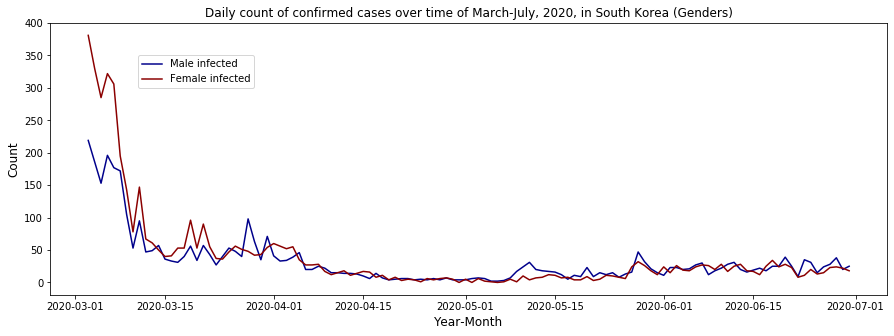

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pd.to_datetime(time_males3['date']), time_males3['confirmed'], color='darkblue', label='Male infected')
ax.plot(pd.to_datetime(time_females3['date']), time_females3['confirmed'], color='darkred', label='Female infected')
plt.legend(bbox_to_anchor=(0.25,0.9))
ax.set_xlabel('Year-Month', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title("Daily count of confirmed cases over time of March-July, 2020, in South Korea (Genders)", fontsize=12)

In [57]:
zscore, pval = weightstats.ztest(time_males3['confirmed'], time_females3['confirmed'], value = 0)
print("z-score: {}; pval: {} for statistical difference between infected male and female populations".format(abs(zscore), pval))

z-score: 0.9121192822442382; pval: 0.3617059288838437 for statistical difference between infected male and female populations


- The z-score value does not exceed 1.96 and p-value does not go lower than 0.05. 
We cannot verify that difference between infected male and infected female population is statistically significant and we fail to reject null hypothesis.

# Logistic regression
In this part we will try to predict patient's state (released or isolated) based on his behavioural data. We will use logistic regression for that. 

- First, let's choose relevant columns and drop deceased cases, because there are only few of them.

In [58]:
df = infection_cases[["sex", "age", "infection", "contact_number", "days", "state"]]
df = df[df['state'] != 'deceased']

- Encode age group with ordinal encoder. 
- Encode infection case with one-hot encoding
- Replace gender and state values with binary values
- Since there are twice as many released states than isolated states, we will have to balance the dataset by choosing a random sample of released cases with a fraction of 0.5.

In [59]:
ordinal_encoder = OrdinalEncoder()

df['age'] = ordinal_encoder.fit_transform(df['age'].values.reshape(-1, 1))
df = pd.get_dummies(df, columns = ['infection'])

df.sex.replace({'male': 0,'female': 1}, inplace=True)
df.state.replace({'released': 0, 'isolated': 1}, inplace=True)

df_released = df[df['state'] == 0]
df_isolated = df[df['state'] == 1]

df_released = df_released.sample(frac=0.5, random_state=1)
df = pd.concat([df_released, df_isolated])

- Split the data into train and test and predict. Summary will be provided with summarize_classification helper function.

In [60]:
X = df.drop(['state'], axis=1)
y = df['state']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

clf = LogisticRegression().fit(xtrain, ytrain)
ypred = clf.predict(xtest)

In [61]:
def summarize_classification(ytest, ypred, avg_method = 'weighted'):
    #accuracy is how many predictions the model got right 
    acc = round(accuracy_score(ytest, ypred, normalize = True), 2)
    num_acc = accuracy_score(ytest, ypred, normalize = False)
    #what part of states that classifier tagged as pos were actual pos 
    prec = round(precision_score(ytest, ypred, average='weighted'), 2)
    #what part of actual positive states classifier identified correctly
    recall = round(recall_score(ytest, ypred, average='weighted'), 2)
    
    print("Length of testing data: ", len(ytest))
    print("accuracy count: ", num_acc)
    print("accuracy score: ", acc)
    print("precision score: ", prec)
    print("recall score: ", recall)

In [62]:
summarize_classification(ytest, ypred)

Length of testing data:  33
accuracy count:  19
accuracy score:  0.58
precision score:  0.58
recall score:  0.58


- Logistic regression on behavioural data does give us good prediction results. This is possibly due to the lack of training data (most symptom onset date values were NaN's, so we had to drop them. Collecting more data on behavioural patterns would help to increase the accuracy of the model).

# Conclusions

- In this analysis we can see that young people tend to get infected the most: lack of responsibility and high levels of activity might be the underlying issues. However, death is most frequent among older people.
- There is no statistical difference between infection rates of men and women
- Main cases of infection - inflow from abroad, contact with infected ones, social facilities and activities
- The first wave was under control at the beginning of April - since then confirmation rate was a fluctuating constant
- Unknown infection case reasons are quite close to abroad ones - some patients might have been conducting some shady business in China and didn't want to admit upon positive confirmation
- Capital and its' surroundings is the most infected region in the country
- In general, first wave was controlled pretty well.

Plan for my country:

- Social distancing, increased awareness between young people
- Absolute isolation of elders
- Closing of all non-vital facilities (including religious ones)
- Restricted travelling abroad
- Wait for vaccine and get back to normal life